In [1]:
#import libraries first
import duckdb 
import pandas as pd 
import numpy as np 
import seaborn as sns
import plotly.express as px
from dotenv import load_dotenv
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Set your MotherDuck token
load_dotenv()

token = os.getenv('motherduck_token')

In [3]:
# Connect to the database
con = duckdb.connect(f"md:?motherduck_token={token}")

# Define your SQL query
sql_query = "SELECT * FROM stocks_clouddb.msft_data"

# Execute the query and fetch the result into a DataFrame
df = con.sql("SELECT * FROM stocks_clouddb.msft_data").fetchdf().copy()

In [4]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

First few rows of the dataset:
             datetime  open_price  day_high   day_low  close_price  \
0 1986-03-12 21:00:00    0.055004  0.063093  0.055004     0.060396   
1 1986-03-13 21:00:00    0.060396  0.063632  0.060396     0.062553   
2 1986-03-16 21:00:00    0.062553  0.064172  0.062553     0.063632   
3 1986-03-17 21:00:00    0.063632  0.064172  0.061475     0.062014   
4 1986-03-18 21:00:00    0.062014  0.062553  0.060396     0.060936   

       volume  dividends  stock_splits  
0  1031788800        0.0           0.0  
1   308160000        0.0           0.0  
2   133171200        0.0           0.0  
3    67766400        0.0           0.0  
4    47894400        0.0           0.0  


In [5]:
df_close=df['close_price']

Check for Stationarity of Time Series 

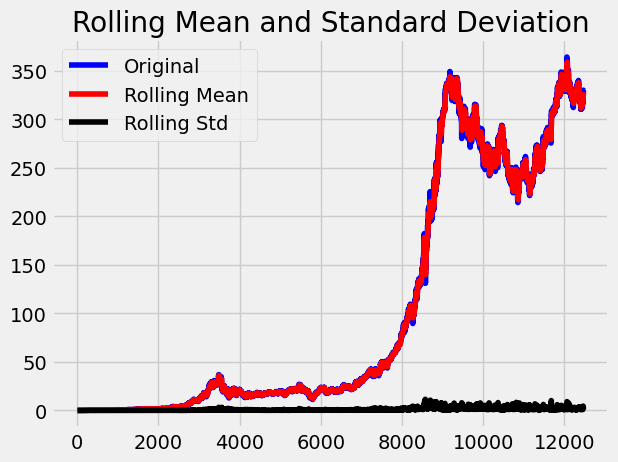

Results of Dickey fuller test
Test Statistics                    0.725975
p-value                            0.990342
No. of lags used                  32.000000
Number of observations used    12437.000000
critical value (1%)               -3.430876
critical value (5%)               -2.861772
critical value (10%)              -2.566894
dtype: float64


In [6]:
def test_stationarity(timeseries):
    #determing rolling statistics 
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #plot rolling statistics: 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black',label ='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of Dickey fuller test") 
    adft= adfuller(timeseries, autolag ='AIC')
# output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)
   

<Figure size 640x480 with 0 Axes>

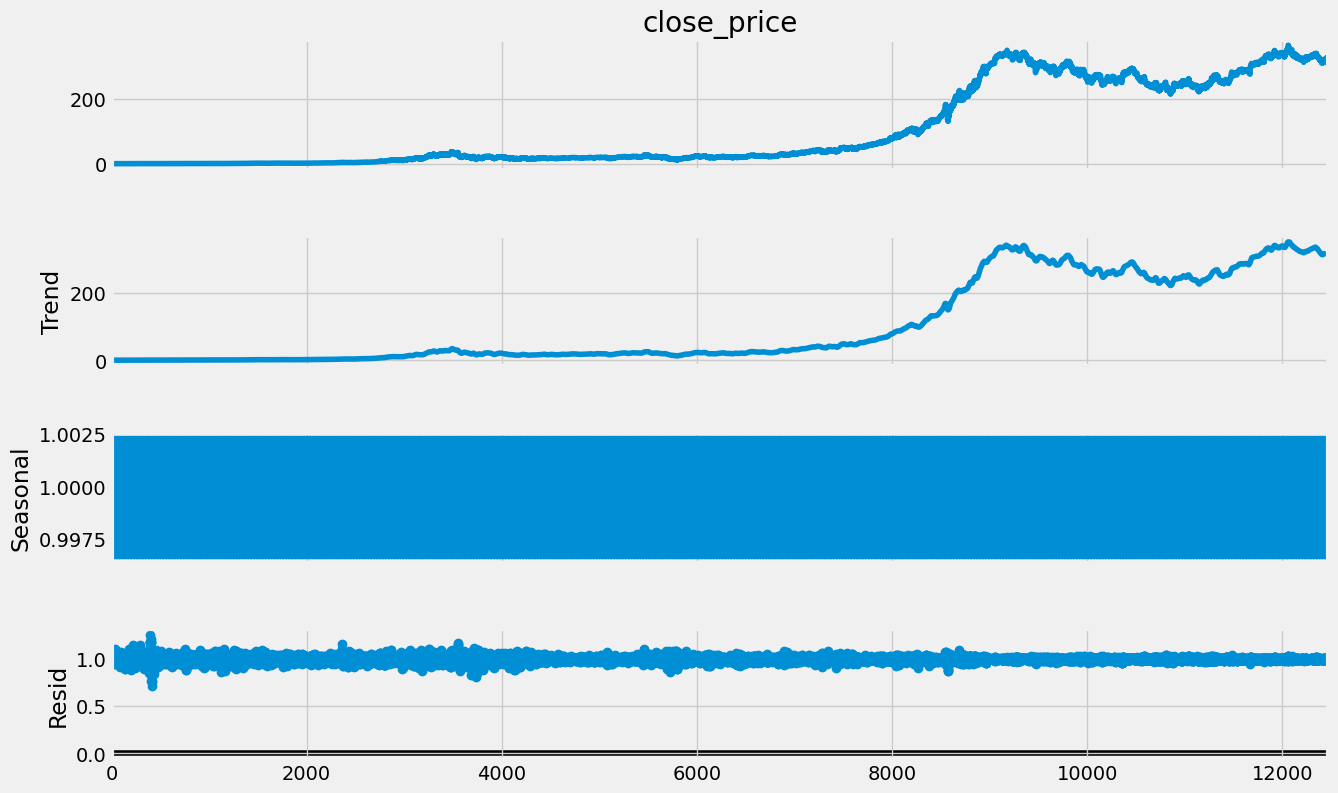

In [7]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


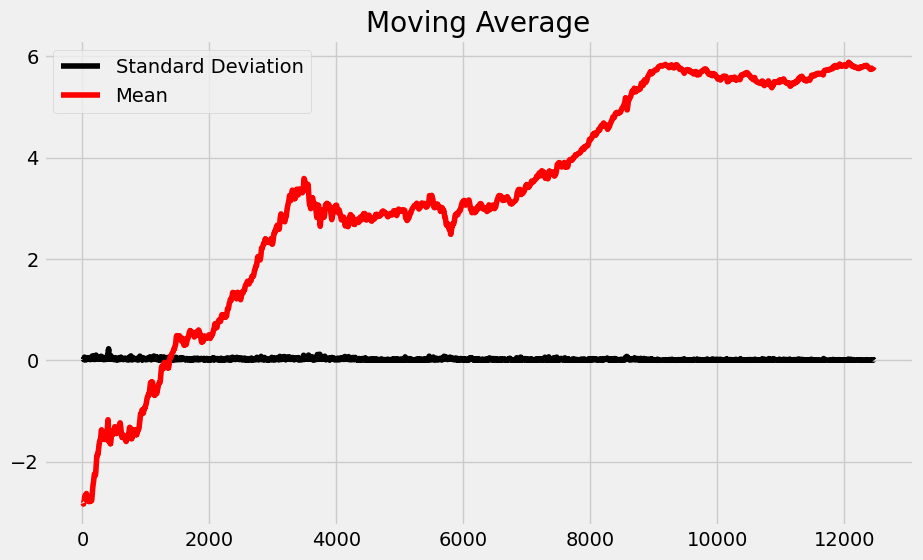

In [8]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

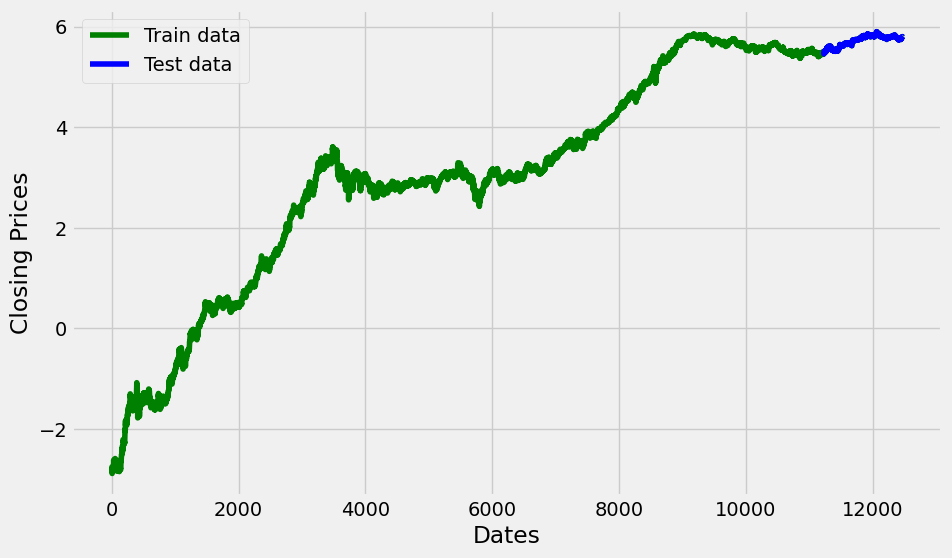

In [9]:
#split data into train and training set and visualize it 
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Auto ARIMA Model 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-56555.483, Time=2.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-56557.035, Time=1.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-56557.308, Time=3.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-56541.384, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-56555.166, Time=3.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-56570.957, Time=2.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-56578.392, Time=3.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-56576.395, Time=3.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-56577.467, Time=2.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-56576.763, Time=5.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-56566.701, Time=2.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-56573.500, Time=8.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-56560.586, Time=2.71 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 40.829 sec

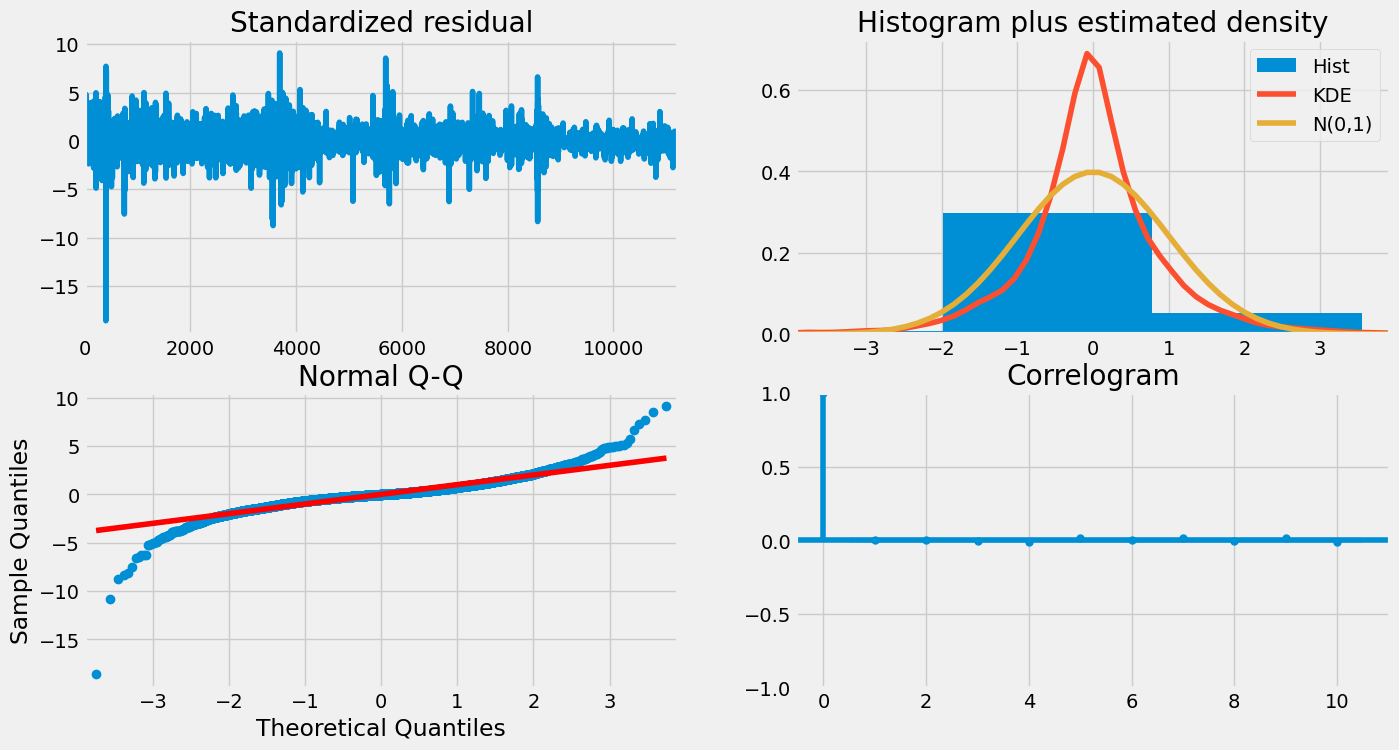

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [11]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:            close_price   No. Observations:                11220
Model:                 ARIMA(1, 1, 2)   Log Likelihood               28284.293
Date:                Mon, 23 Oct 2023   AIC                         -56560.586
Time:                        10:53:01   BIC                         -56531.284
Sample:                             0   HQIC                        -56550.724
                              - 11220                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4885      0.101      4.825      0.000       0.290       0.687
ma.L1         -0.5072      0.101     -5.043      0.000      -0.704      -0.310
ma.L2         -0.0257      0.006     -4.362      0.0

In [12]:
# Forecast
#fc = fitted.forecast(steps=321, alpha=0.05)  # 95% conf

# Forecast
fc = fitted.forecast(steps=len(test_data), alpha=0.05)  # Ensure fc has the same length as test_data


c:\Users\Admin\miniconda3_Used_this_one\envs\stock-price-predition-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [13]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)

In [14]:
# Calculate the lower and upper bounds of the confidence interval manually
forecast_std = fitted.get_prediction(start=0, end=len(train_data) - 1).se_mean
alpha = 0.05  # 95% confidence interval
z = stats.norm.ppf(1 - alpha / 2)
lower_series = fc - z * forecast_std
upper_series = fc + z * forecast_std


In [15]:
lower_series = pd.Series(lower_series, index=test_data.index)
upper_series = pd.Series(upper_series, index=test_data.index)


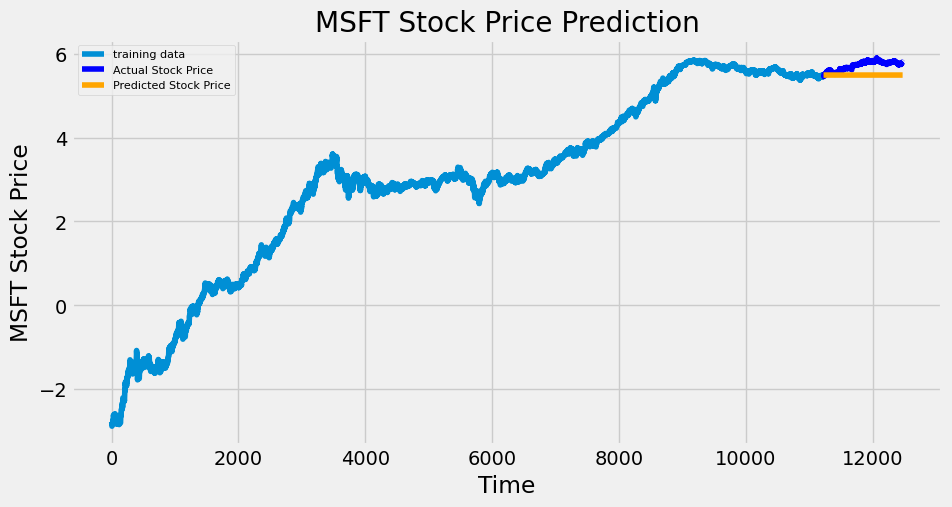

In [16]:


#lower_series = pd.Series(conf[:, 0], index=test_data.index)
#upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('MSFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [17]:
#fc = fc[:len(test_data)]
# fc_length = len(fc)
# print("Length of fc:", fc_length)


In [18]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.062419646512941865
MAE: 0.22590033564332915
RMSE: 0.24983924133918967
MAPE: 0.03917656781248877


LSTM Model 

In [20]:
import tensorflow as tf
import sklearn 
import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, LSTM
from sklearn.model_selection import TimeSeriesSplit
#from vis.utils import plot_model
#from keras.utils.vis_utils import plot_model


In [21]:
data= df.filter(['close_price'])

In [22]:
#convert the dataframe to a numpy array 
dataset = data.values 

In [23]:
#Get the number of rows to train the model on 
training_data_len = math.ceil(len(dataset)*0.8)
training_data_len

9976

In [24]:
# scaling the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[1.18476052e-05],
       [1.77714180e-05],
       [2.07350638e-05],
       ...,
       [9.06070739e-01],
       [9.04807387e-01],
       [9.05686277e-01]])

In [26]:
#create the training dataset 
#create the scaled training dataset 
train_data = scaled_data[0:training_data_len, :]

#split the data into x_train and y_train dataset 
X_train=[]
y_train =[]

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    #set 60 as the time step 
    if i < 61: 
        print(X_train)
        print(y_train)
        print()

[array([1.18476052e-05, 1.77714180e-05, 2.07350638e-05, 1.62904137e-05,
       1.33285789e-05, 8.88565786e-06, 4.44281870e-06, 0.00000000e+00,
       2.96188595e-06, 7.40474557e-06, 1.03665804e-05, 8.88565786e-06,
       7.40474557e-06, 8.88565786e-06, 1.03665804e-05, 1.03665804e-05,
       7.40474557e-06, 8.88565786e-06, 1.18476052e-05, 1.33285789e-05,
       1.62904137e-05, 1.77714180e-05, 1.77714180e-05, 2.36969088e-05,
       2.51779029e-05, 1.92540083e-05, 1.92540083e-05, 1.62904137e-05,
       1.70309414e-05, 3.40636426e-05, 4.59128849e-05, 4.73937971e-05,
       4.14683268e-05, 3.70255081e-05, 3.40636426e-05, 3.40636426e-05,
       3.25826076e-05, 3.40636426e-05, 3.40636426e-05, 3.55444731e-05,
       3.40636426e-05, 3.55444731e-05, 3.70255081e-05, 3.55444731e-05,
       3.55444731e-05, 3.70255081e-05, 3.40636426e-05, 3.25826076e-05,
       2.96207830e-05, 2.96207830e-05, 2.96207830e-05, 3.55444731e-05,
       4.14683268e-05, 4.59128849e-05, 5.33177327e-05, 4.73937971e-05,
     

In [27]:
#convert the x_train and y_train to numpy arrays 
X_train, y_train = np.array(X_train), np.array(y_train)

In [28]:
# Reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True , input_shape = (X_train.shape[1],1))) 
model.add(LSTM(50, return_sequences=False)) 
#model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))


#activation='relu', ))
# Build the model
#model.build(input_shape=(None, 1, 3))  #  specify the input shape: 3 variables

#model.summary()

In [30]:

#compile the model 
model.compile(optimizer='adam', loss='mse')

In [31]:
#Model Training 
history = model.fit(X_train, y_train, epochs =25, batch_size = 8, verbose =1, shuffle = False)

Epoch 1/25
1240/1240 [==============================] - 164s 116ms/step - loss: 2.2166e-04
Epoch 2/25
1240/1240 [==============================] - 128s 103ms/step - loss: 0.0023
Epoch 3/25
1240/1240 [==============================] - 122s 98ms/step - loss: 0.0021
Epoch 4/25
1240/1240 [==============================] - 103s 83ms/step - loss: 0.0019
Epoch 5/25
 327/1240 [======>.......................] - ETA: 59s - loss: 0.0056

In [ ]:
loss_per_epoch = history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

In [ ]:
#Create the testing dataset 
#create a new array containing scaled values 
test_data = scaled_data[training_data_len -60:, :]

#create the dataset x_test and y_test 
x_test =[]
y_test = dataset[training_data_len:,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])



In [ ]:
#convert the data to a numpy array 

x_test = np.array(x_test )


In [ ]:
#reshape the data 
x_test= np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))


In [ ]:
#get the model predicted price values 

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
#Get the root mean squared error (RMSE)
rmse= np.sqrt(np.mean(predictions -y_test)**2) 
rmse 

In [ ]:
# plot the data 

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions 

#visualize the data 
plt.figure (figsize = (16,8))
plt.title('Model ')
plt.xlabel('Data', fontsize =18)
plt.ylabel('Close Price USD $', fontsize=18)

plt.plot(train['close_price'])
plt.plot(valid[['close_price', 'Predictions']])
plt.legend(['Train','Valid','Predictions'], loc='lower right')
plt.show()

In [ ]:
#show the valid and predicted prices 
valid 

In [ ]:
# predicted vs True close values - LSTM 

plt.plot(y_test, label='True Value')
plt.plot(y_pred, label ='LSTM Predicted Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()